# Setting up workbook

In [13]:
import os, sys, logging, datetime, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import zscore

# adding module directory to path
modules_path = os.path.join(os.getcwd(),'modules')
sys.path.insert(0, modules_path)

from config_handler import ConfigHandling
from data_handler import DataHandling
# from feature_handler import FeatureHandling
# from model_handler import ModelHandling

In [14]:
cfg = ConfigHandling(job_directory = os.getcwd(), config_filename='config.json')

# Define helper functions

In [15]:
def countPlot(x, data, title="", fig_size = (15,5)):
    plt.rcParams['figure.figsize'] = fig_size
    sns.countplot(x=x, data=data).set_title(title)
    plt.show()
    
def barPlot(x, y, data, title="", fig_size = (15,5)):
    plt.rcParams['figure.figsize'] = fig_size
    sns.barplot(x=x, y=y, data=data).set_title(title)
    plt.show()

def boxPlot(x, y, data, title="", fig_size = (15,5)):
    plt.rcParams['figure.figsize'] = fig_size
    sns.boxplot(x=x, y=y, data=data).set_title(title)
    plt.show()

In [16]:
def spearman(frame, features, threshold=0):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['response'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    spr = spr[spr['spearman'].abs() > threshold]
    plt.figure(figsize=(6, 0.3*len(spr)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    return spr

In [17]:
def select_features(X, y):
    fs = SelectKBest(score_func=mutual_info_classif, k='all')
    fs.fit(X, y)
    X_fs = fs.transform(X)
    return X_fs, fs

# Read train/test data and data cleaning

In [18]:
data = DataHandling(cfg)

data_train = data.read_data(dataset='train')
data_submission = data.read_data(dataset='test')
data_full = data_train.append(data_submission)

train has shape: (382154, 12)
test has shape: (78273, 11)


In [19]:
# Adjust data types

data_train = data_train.astype({
    'region_code': 'O',
    'policy_sales_channel': 'O',
})

# EDA

## View distribution of continuous variables
- The main continuous variable has no erroneous looking value (min is ~54).

In [20]:
data_full.describe()

,cust_id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,days_since_insured,response
count,460427.000000,460427.000000,460427.000000,460427.000000,460427.000000,460427.000000,460427.000000,460427.000000,382154.000000
mean,234325.116381,38.539210,0.998067,26.402544,0.489137,614.054932,111.948891,154.297854,0.163811
std,139482.954692,15.225135,0.043923,13.175887,0.499883,341.161560,54.283653,83.691475,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,52.599998,1.000000,10.000000,0.000000
25%,115107.500000,25.000000,1.000000,15.000000,0.000000,490.899994,26.000000,82.000000,0.000000
50%,230214.000000,36.000000,1.000000,28.000000,0.000000,634.000000,145.000000,154.000000,0.000000
75%,345320.500000,49.000000,1.000000,35.000000,1.000000,789.000000,152.000000,227.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,10803.299805,163.000000,299.000000,1.000000


## Null Values
- Fortunately for the purpose of this case study there are no missing values that need to be imputed.
- However should the need arise we can put methods in place during feature handling (MinMax, Standard) to handle the missing values

In [21]:
print("Null Values")
print("==========================")
print(data_train.isna().sum()/len(data_train)*100)

Null Values
cust_id                 0.0
gender                  0.0
age                     0.0
driving_license         0.0
region_code             0.0
previously_insured      0.0
vehicle_age             0.0
vehicle_damage          0.0
annual_premium          0.0
policy_sales_channel    0.0
days_since_insured      0.0
response                0.0
dtype: float64


## Data types
- There are several data types that need to be refactored to be categorical, namely region_code and policy_sales_channel as these should be categorical variables.
- As expected, region_code and policy_sales_channel have high cardinality, and we will be selecting the best way to reduce the cardinality before fitting into our model.

In [22]:
print("Data Types")
print("==========================")
print(data_train.info())

Data Types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   cust_id               382154 non-null  int32  
 1   gender                382154 non-null  object 
 2   age                   382154 non-null  int32  
 3   driving_license       382154 non-null  int32  
 4   region_code           382154 non-null  object 
 5   previously_insured    382154 non-null  int32  
 6   vehicle_age           382154 non-null  object 
 7   vehicle_damage        382154 non-null  object 
 8   annual_premium        382154 non-null  float32
 9   policy_sales_channel  382154 non-null  object 
 10  days_since_insured    382154 non-null  int32  
 11  response              382154 non-null  int32  
dtypes: float32(1), int32(6), object(5)
memory usage: 24.8+ MB
None


In [23]:
data_train.dtypes

cust_id                   int32
gender                   object
age                       int32
driving_license           int32
region_code              object
previously_insured        int32
vehicle_age              object
vehicle_damage           object
annual_premium          float32
policy_sales_channel     object
days_since_insured        int32
response                  int32
dtype: object

In [24]:
for i,v in enumerate(data_train.dtypes):
    print(f"{data_train.columns[i]}: {data_train[data_train.columns[i]].unique()}")
    print("=====================\n")

cust_id: [167647  17163  32023 ... 165293 383241 401019]

gender: ['Male' 'Female']

age: [22 42 66 28 25 51 38 45 26 33 76 23 49 52 24 21 48 35 36 44 60 57 56 73
 54 50 72 58 41 27 61 59 29 64 37 46 31 68 39 63 40 30 62 69 65 78 79 55
 74 47 34 67 53 70 32 43 71 20 77 75 80 81 85 83 82 84]

driving_license: [1 0]

region_code: [7 28 33 46 25 8 41 39 13 14 36 3 43 45 48 11 30 15 6 50 38 19 34 22 29 35
 12 37 4 10 40 24 31 21 2 52 9 49 5 47 1 20 42 27 26 32 18 16 17 51 0 23
 44]

previously_insured: [1 0]

vehicle_age: ['< 1 Year' '1-2 Year' '> 2 Years']

vehicle_damage: ['No' 'Yes']

annual_premium: [  52.6  866.5  716.8 ... 1397.5 2509.8 1343.5]

policy_sales_channel: [152 26 124 122 158 157 156 160 24 153 55 1 8 88 13 11 163 151 7 9 15 31
 120 30 150 25 61 154 64 155 113 108 125 52 121 16 44 14 29 4 54 3 111 60
 12 46 103 42 65 136 109 91 34 106 22 53 139 127 105 21 131 37 23 45 159
 98 18 19 137 145 128 135 59 40 138 82 116 129 56 10 2 107 147 17 35 47
 140 32 134 36 39 132 94 97 11

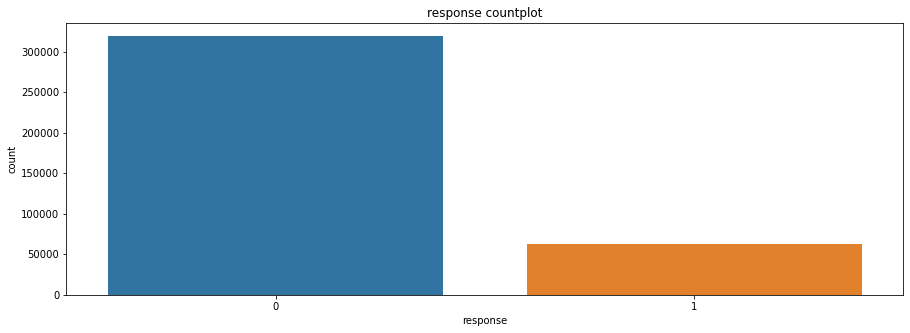

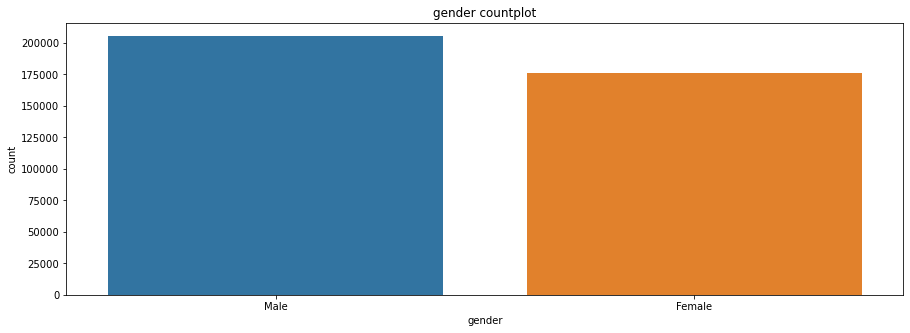

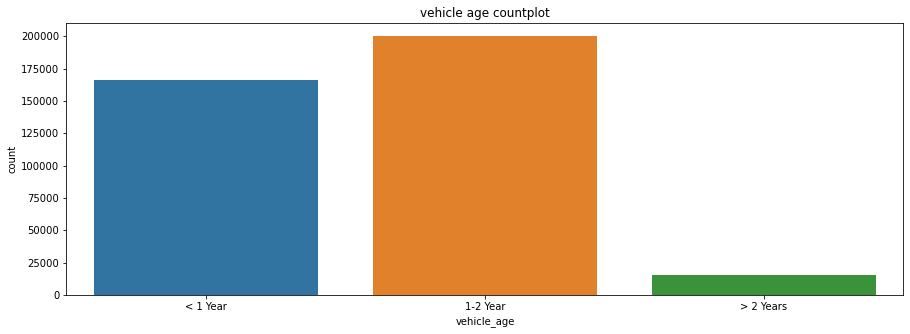

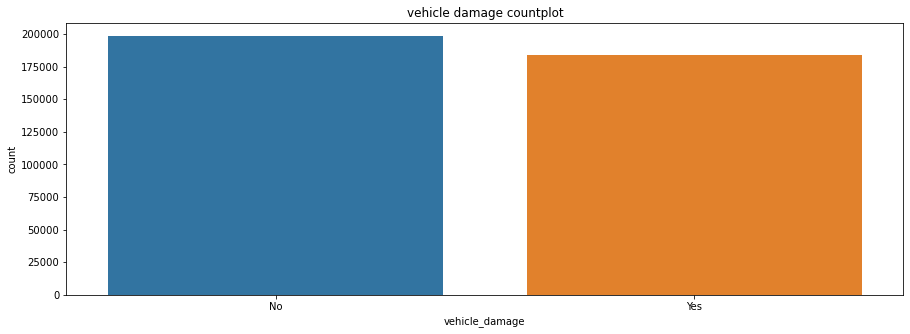

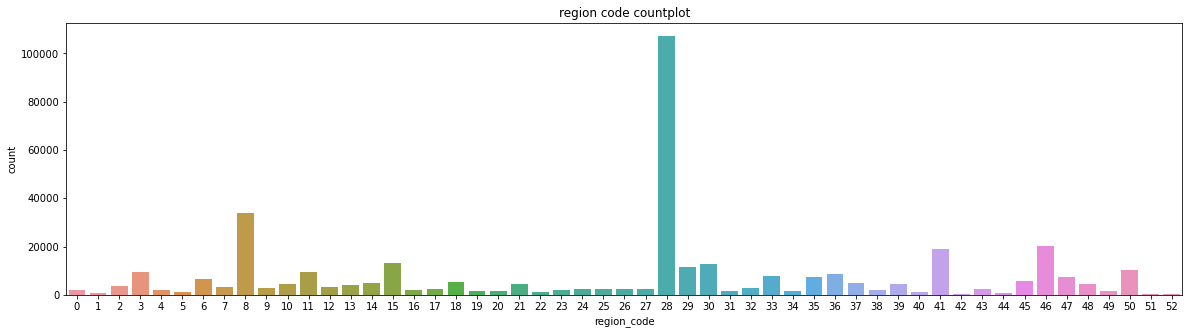

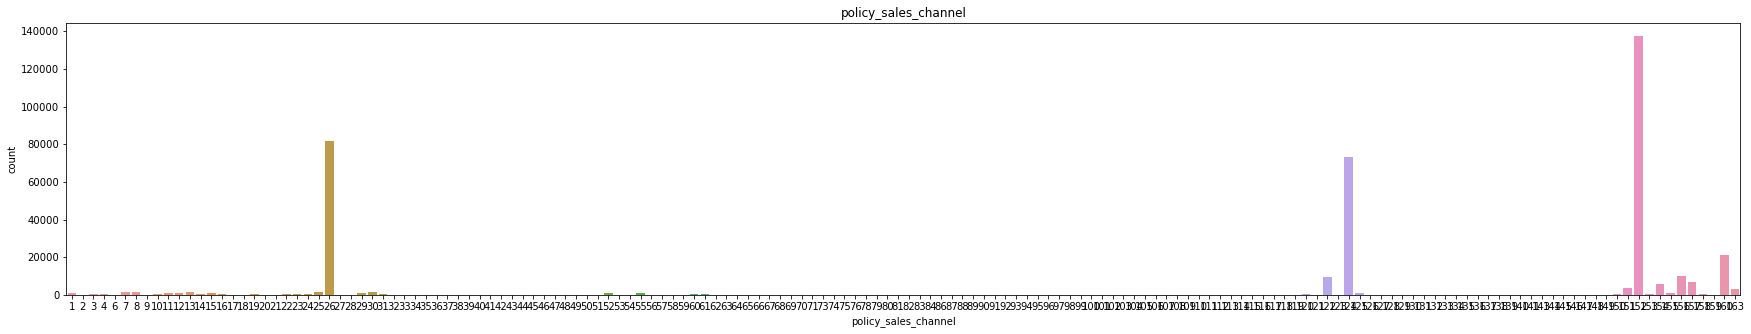

In [25]:
# Categorical Variables
# gender, age, driving_license, region_code, previously_insured, vehicle_age, vehicle_damage, policy_sales_channel

countPlot(x="response", data=data_train, title="response countplot")
countPlot(x="gender", data=data_train, title="gender countplot")
countPlot(x="vehicle_age", data=data_train, title="vehicle age countplot")
countPlot(x="vehicle_damage", data=data_train, title="vehicle damage countplot")
countPlot(x="region_code", data=data_train, title="region code countplot", fig_size=(20,5))
countPlot(x="policy_sales_channel", data=data_train, title="policy_sales_channel", fig_size=(30,5))

## Correlation analysis
- Adjust several data types.
- Before we perform correlation analysis we will be one-hot encoding that need to be one hot encoded or map binary variables.
    - to OHE: region_code, vehicle_age, policy_sales_channel
    - to binarise: gender, vehicle_damage
- For two columns that are have high cardinality (region_code and policy_sales_channel) we will only take those with high correlation, the remainders will be grouped.

In [14]:
ohe_columns = [
    'region_code', 'vehicle_age', 'policy_sales_channel'
]

one_hot_encode = pd.get_dummies(data_train[ohe_columns])
data_train_encode = pd.concat([data_train, one_hot_encode], axis = 1)

In [15]:
data_train_encode['gender_binary'] = data_train_encode['gender'].map({
    'Male': 1,
    'Female': 0
})

data_train_encode['vehicle_damage_binary'] = data_train_encode['vehicle_damage'].map({
    'Yes': 1,
    'No': 0
})

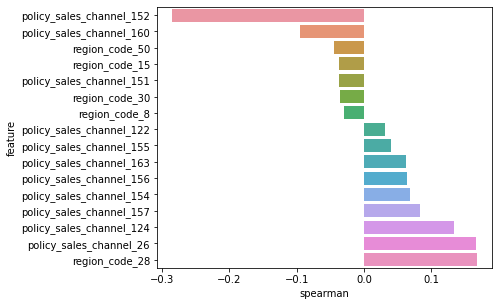

In [16]:
# Select only columns with relatively high correlation to reduce cardinality

matchers = ['policy_sales_channel_','region_code_']
encode_column = [s for s in data_train_encode.columns if any(xs in s for xs in matchers)]

features = encode_column
correlation_categorical = spearman(data_train_encode, features, threshold = 0.03)

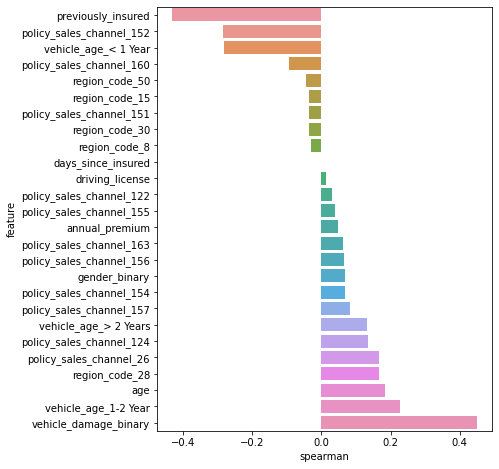

In [17]:
matchers = list(correlation_categorical['feature']) + ['vehicle_age_']
encode_column = [s for s in data_train_encode.columns if any(xs in s for xs in matchers)]

categorical_columns = [
    'gender_binary',  'driving_license', 
    'previously_insured', 'vehicle_damage_binary',
] + encode_column

numeric_columns = ['age', 'annual_premium', 'days_since_insured']

features = categorical_columns + numeric_columns
correlation = spearman(data_train_encode, features)

# Analysing relationship between variables

In [37]:
# Some wrangling to make plotting easier
# Hardcoded for simplicity - will have to dynamically select in production.

policy_sales_channel_filter = [
    26,15,122,124,151,152,154,155,156,157,160,163
]

region_code_filter = [
    8,28,30,50
]

data_train_rship = data_train.copy()
data_train_rship['policy_sales_channel'][~data_train_rship['policy_sales_channel'].isin(policy_sales_channel_filter)] = 'others'
data_train_rship['region_code'][~data_train_rship['region_code'].isin(region_code_filter)] = 'others'

<ipython-input-37-24b3fd6ba624>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_rship['policy_sales_channel'][~data_train_rship['policy_sales_channel'].isin(policy_sales_channel_filter)] = 'others'
<ipython-input-37-24b3fd6ba624>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_rship['region_code'][~data_train_rship['region_code'].isin(region_code_filter)] = 'others'


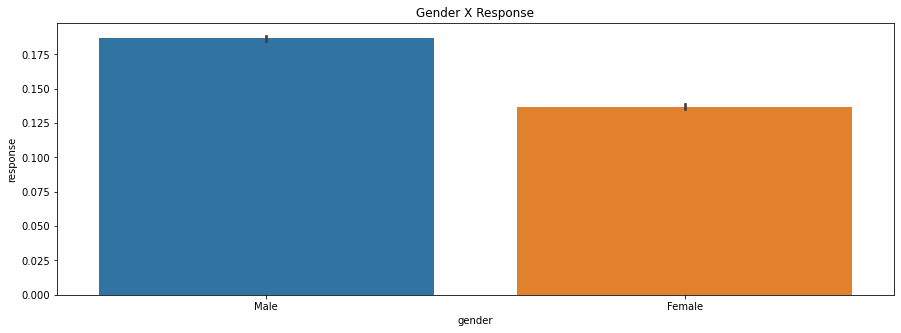

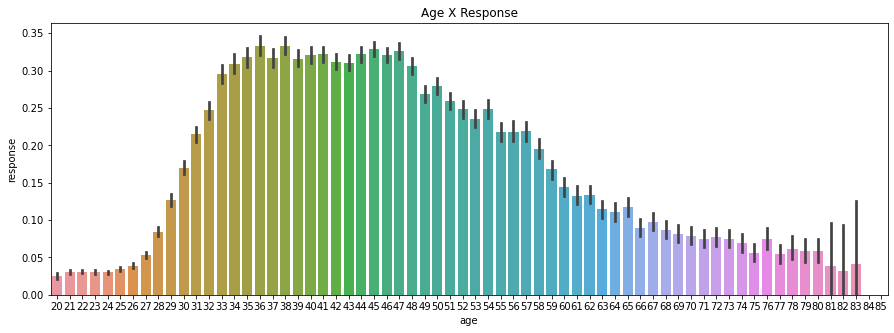

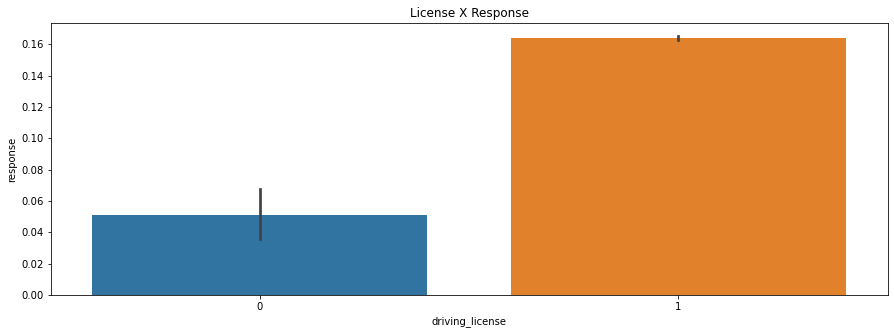

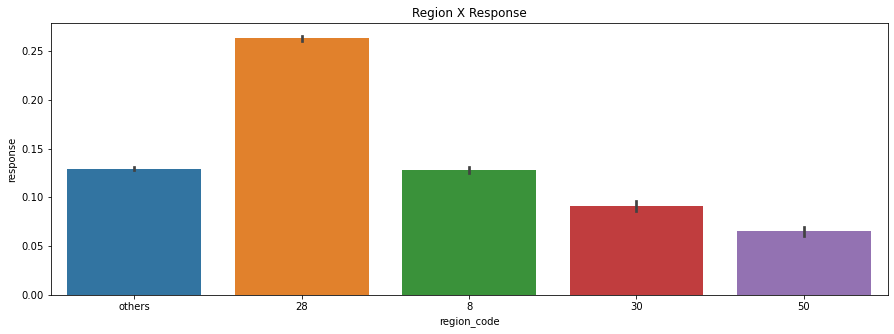

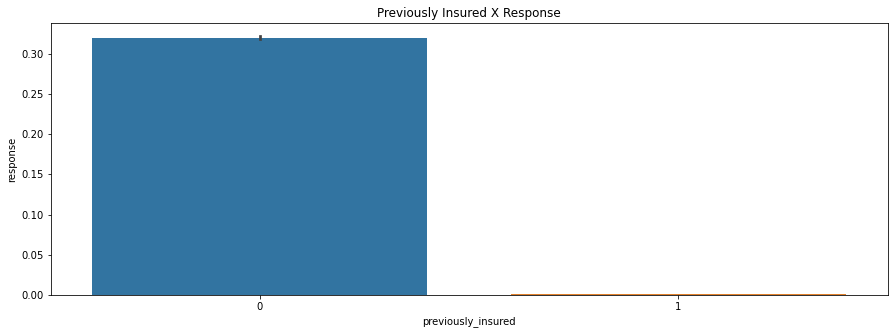

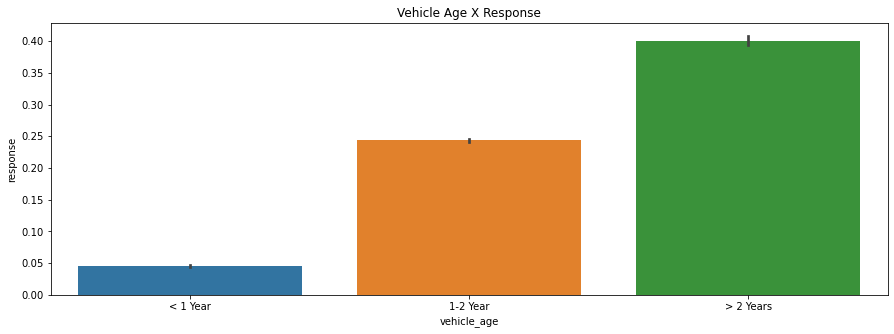

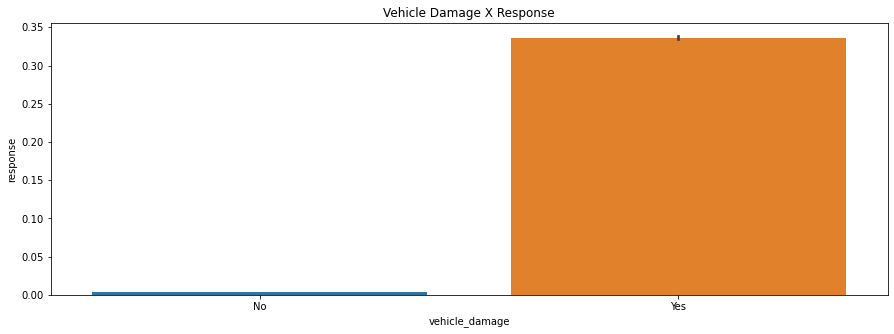

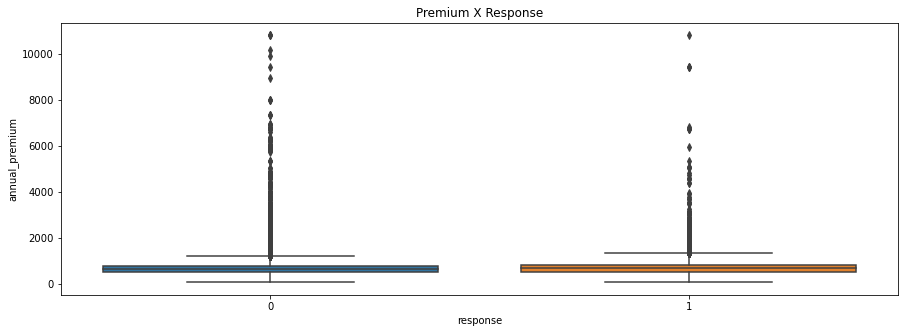

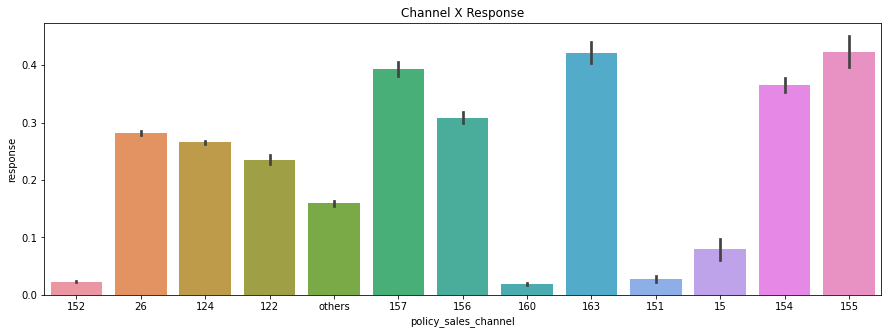

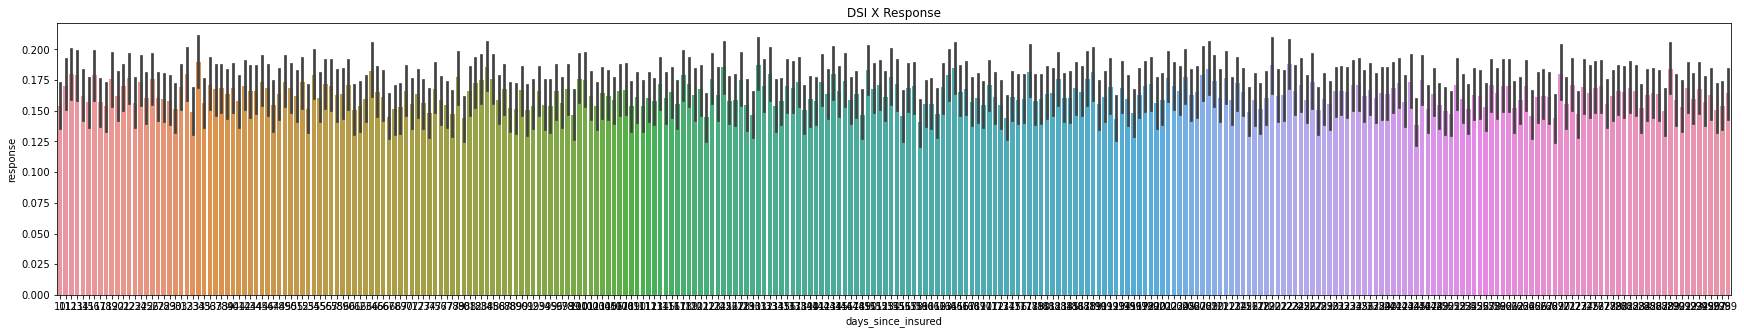

In [42]:
barPlot(x='gender', y='response', data=data_train_rship, title="Gender X Response")
barPlot(x='age', y='response', data=data_train_rship, title="Age X Response")
barPlot(x='driving_license', y='response', data=data_train_rship, title="License X Response")
barPlot(x='region_code', y='response', data=data_train_rship, title="Region X Response")
barPlot(x='previously_insured', y='response', data=data_train_rship, title="Previously Insured X Response")
barPlot(x='vehicle_age', y='response', data=data_train_rship, title="Vehicle Age X Response")
barPlot(x='vehicle_damage', y='response', data=data_train_rship, title="Vehicle Damage X Response")
boxPlot(x='response', y='annual_premium', data=data_train_rship, title="Premium X Response")
barPlot(x='policy_sales_channel', y='response', data=data_train_rship, title="Channel X Response")
barPlot(x='days_since_insured', y='response', data=data_train_rship, title="DSI X Response", fig_size=(30,5))

# ETL section: Preparing training data to be fed into model
- Cleaning data to be fed into GBClassifier model.
- Two datasets to be cleaned: train.csv and test.csv.

In [48]:
data = DataHandling(cfg)
data_train = data.read_data(dataset='train')
data_submission = data.read_data(dataset='submission')

train has shape: (382154, 12)
submission has shape: (78273, 11)


In [49]:
# Adjust data types

data_train = data_train.astype({
    'region_code': 'O',
    'policy_sales_channel': 'O',
})

data_submission = data_submission.astype({
    'region_code': 'O',
    'policy_sales_channel': 'O',
})

In [50]:
# Hardcoded for simplicity - will have to dynamically select in production.

policy_sales_channel_filter = [
    26,15,122,124,151,152,154,155,156,157,160,163
]

region_code_filter = [
    8,28,30,50
]

data_train_clean = data_train.copy()
data_train_clean['policy_sales_channel'][~data_train_clean['policy_sales_channel'].isin(policy_sales_channel_filter)] = 'others'
data_train_clean['region_code'][~data_train_clean['region_code'].isin(region_code_filter)] = 'others'

data_submission_clean = data_submission.copy()
data_submission_clean['policy_sales_channel'][~data_submission_clean['policy_sales_channel'].isin(policy_sales_channel_filter)] = 'others'
data_submission_clean['region_code'][~data_submission_clean['region_code'].isin(region_code_filter)] = 'others'

<ipython-input-50-2c3d9020c838>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_clean['policy_sales_channel'][~data_train_clean['policy_sales_channel'].isin(policy_sales_channel_filter)] = 'others'
<ipython-input-50-2c3d9020c838>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_clean['region_code'][~data_train_clean['region_code'].isin(region_code_filter)] = 'others'
<ipython-input-50-2c3d9020c838>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [51]:
ohe_columns = [
    'region_code', 'vehicle_age', 'policy_sales_channel'
]

one_hot_encode_train = pd.get_dummies(data_train_clean[ohe_columns])
data_train_clean = pd.concat([data_train_clean, one_hot_encode_train], axis = 1)

one_hot_encode_submission = pd.get_dummies(data_submission_clean[ohe_columns])
data_submission_clean = pd.concat([data_submission_clean, one_hot_encode_submission], axis = 1)

In [52]:
data_train_clean['gender_binary'] = data_train_clean['gender'].map({
    'Male': 1,
    'Female': 0
})

data_train_clean['vehicle_damage_binary'] = data_train_clean['vehicle_damage'].map({
    'Yes': 1,
    'No': 0
})

data_submission_clean['gender_binary'] = data_submission_clean['gender'].map({
    'Male': 1,
    'Female': 0
})

data_submission_clean['vehicle_damage_binary'] = data_submission_clean['vehicle_damage'].map({
    'Yes': 1,
    'No': 0
})

In [53]:
data_train_clean.to_csv(cfg.train_data_clean_path, index=False)

In [54]:
data_submission_clean.to_csv("data/test_data_clean.csv", index=False)